# Deriving the LF parameter prior

TL;DR

All LF model parameters can be derived from statistics in [@Holmberg1988, Tables A1-A2] for an American population. See `holmberg.ipynb`. See [@Holmberg1989] for a good explanation of these statistics (that's where the abbreviations like ACFL come from). The statistics are:

1. $T_0$, the pitch period
6. $T_d = U_0/E_e$, the declination time. $U_0$ = **ac flow** (ACFL) and $E_e$ = **maximum airflow declination rate** (MFDR).
2. $E_e$: the vertical amplitude.
3. $O_q$: the open quotient,
4. $\alpha_m$, via the **speed quotient** (SPQU) $S_q$ and thus $\alpha_m$ by $\alpha_m = 3_q/(1+S_q)$ (Doval 2006).
5. $Q_a$, via the **closing quotient** (CLQU): $Q_a \simeq t_2/t_3 = CLQU/(1-O_q)$

However, these are *marginal* statistics and don't capture correlations. The correlations can be supplied using Fant (1994)'s "transformed LF" model. The three **'driving variables'** from which all other are regressed are:

1. $T_0$, the pitch period (we derive a prior for this)
2. $T_d$, the declination time (we derive a prior for this)
3. $E_e$: the vertical amplitude (always one because we work modulo scaling)

Thus, the secondary variables which are calculated from the three previous ones are:

1. $O_q$,
2. $\alpha_m$
3. $Q_a$

Bounds for all these variables can be deduced from Holmberg (1988, 1989a). But we use the theoretical bounds as this is easier and won't influence the results downstream for $\theta$ anyway.

The regression happens through Fant (1994). There are three equivalent sets of parameters, which can be converted to one another with `lfmodel.convert_lf_params()`:

1. The `T` set: original LF parameters (Fant 1985) which are used in `lfmodel.dgf()`.
2. The `R` set: rescaled ("ratios") LF parameters which can be regressed from $(T_0, T_d, E_e)$ per Fant (1994)
3. The `generic` set per Doval (2006). This is a set of variables which is well-behaved and properly bounded and 'universal'; therefore it is the set we actually model with our prior `lf.generic_params_prior()`.

## Nice quotes about LF

Note: LF does not allow **negative flow**, like ours. The only GF model that does that is the Fujisaki model:
> Note that contrarily to all other models, this [Fujisaki]
one does not exclude a negative flow due for instance to a lowering of the vocal folds following the
glottal closure. [@Degottex2010, p. 35]

LF model is the most used:
> Besides being the most used model, this one is also the
most studied in terms of spectral properties [van03, Hen01, DdH06, FL88] [@Degottex2010, p. 35]

Use the LF model to control phonation mode with the `Re` parameter: (called `Rd` here)
> This allows one to easily control the voice source with
a single parameter, which runs from Rd = 0.3 for a very adducted phonationtense, to Rd = 2.7 for a very abducted phonation
(see [@Fant1995]). From the Rd range [0.3, 2.7] two extreme values
plus a middle one were chosen. We used Rd = 0.3 to generate a **tense** phonation, Rd = 2.7 for a **lax** production, and
Rd = 1 for a **normal (modal)** voice quality [@Freixes2018]

In [1]:
%run init.ipy

from dgf.prior import lf
from dgf import constants
from lib import lfmodel
from lib import klatt

import corner

rng = np.random.default_rng(3548)

## Sampling Fant's `R` parameters

Note that `Rg` can be larger than 1, unlike `Ra `and `Rg` (Fant 1994, Fig. 3), because it is actually an inverse ratio: $R_g = T_0/2T_p$.

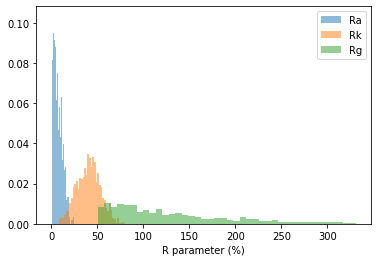

In [2]:
samples = np.vstack([lf.sample_R_triple(Re, rng) for Re in uniform(0.3, 2.7, size=1000)])
R = dict(Ra = samples[:,0], Rk = samples[:,1], Rg = samples[:,2])

for k, v in R.items():
    hist(v*100, density=True, bins=40, alpha=.5, label=k);

legend()
xlabel("R parameter (%)")
show()

## Sampling the LF parameters and fitting a prior

`p` contains all three parametrizations: `R`, `T`, and `generic`.

In [3]:
%%time
p = lf.sample_lf_params()

[Memory]3.4s, 0.1min    : Loading sample_lf_params...
CPU times: user 5.38 ms, sys: 4.41 ms, total: 9.79 ms
Wall time: 17.6 ms


In [4]:
samples = np.vstack([p[v] for v in constants.LF_GENERIC_PARAMS]).T
samples.shape

(65913, 4)

One interesting extra correlation not shown here is that of `p['power']` with the generic LF parameters. It has the clearest, most Gaussian-like correlations (in the z domain) but is strictly not an LF generic parameter, so not shown here.

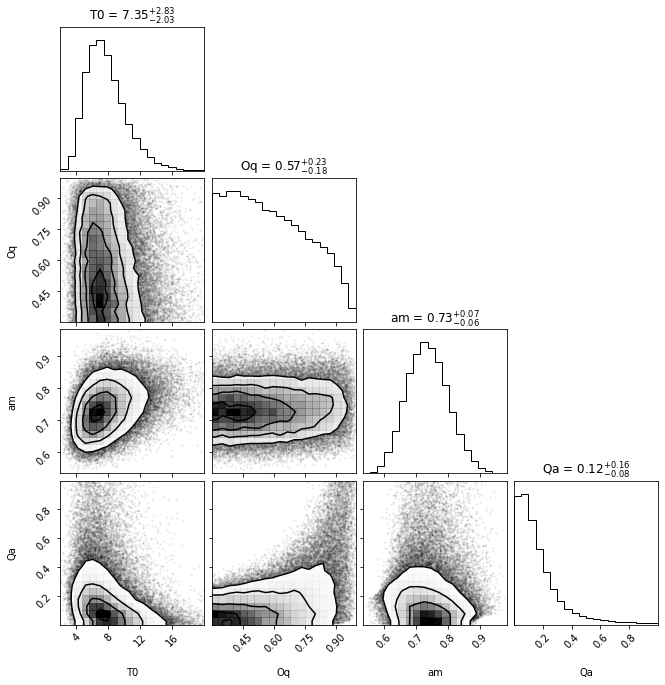

In [5]:
# Cornerplot of regressed (simulated) samples
fig = corner.corner(
    samples,
    labels=constants.LF_GENERIC_PARAMS,
    show_titles=True,
    smooth=.2
)

In [6]:
prior = lf.generic_params_prior()

[Memory]4.9s, 0.1min    : Loading sample_lf_params...
[Memory]5.4s, 0.1min    : Loading run_nested...


The samples and their probability are well behaved, unlike with our previous version where there would be ginormous outliers of the log prob.

In [7]:
theta, theta_lp = prior.experimental_sample_and_log_prob(samples.shape[0], seed=jax.random.PRNGKey(10))

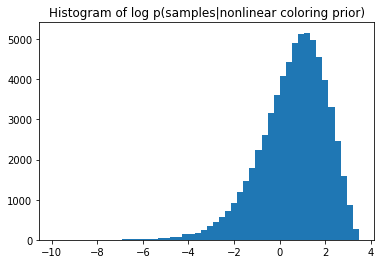

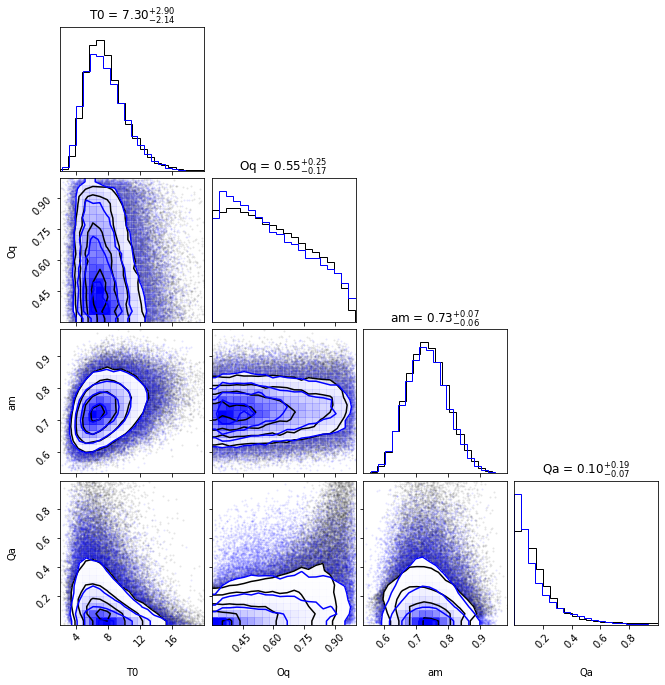

In [8]:
hist(np.array(theta_lp),bins=50)
title("Histogram of log p(samples|nonlinear coloring prior)")
show();

# Overlaying with an alpha is not possible, see https://github.com/dfm/corner.py/issues/112
corner.corner(
    np.array(theta),
    labels=constants.LF_GENERIC_PARAMS,
    show_titles=True,
    smooth=.2,
    fig=fig,
    color="blue"
)

## Simulate trajectories of the generic LF parameters

The envelope function is the one of the period learned from APLAWD.

[Memory]8.0s, 0.1min    : Loading sample_lf_params...
[Memory]8.0s, 0.1min    : Loading run_nested...
[Memory]8.0s, 0.1min    : Loading model_true_pitch_periods...
[Memory]8.0s, 0.1min    : Loading model_praat_pitch_periods...
log p(x) = 512.0488998992389


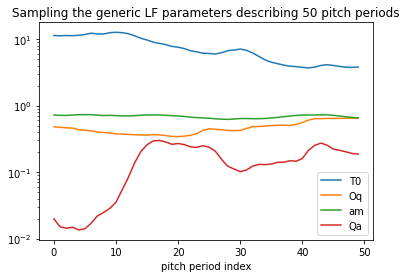

In [9]:
num_pitch_periods = 50
prior = lf.generic_params_trajectory_prior(num_pitch_periods)

x = prior.sample(seed=jaxkey(5))

title(f'Sampling the generic LF parameters describing {num_pitch_periods} pitch periods')
plot(x, label=constants.LF_GENERIC_PARAMS)
yscale('log')
legend()
xlabel('pitch period index')

# The log prob can become inf for big `num_pitch_periods` because the variables
# hit their bounds. The inf comes from `bijectors.bounded_exp_bijector()`
print('log p(x) =', prior.log_prob(x))

## Convert the trajectories into DGF waveforms

The inferred lengthscale sounds unrealistic, but this is normal and due to the data: we learned the lengthscale from generally short fragments of voiced speech, with 75% of data points having a length of less than 53 consecutive pitch periods.

**About the log probability of the sampled $u(t)$.** It is possible to calculate the probability of the sampled *waveforms* (which is not equal to the probability of the underlying samples) similarly as is done in `source.py`. First calculate the probability `log_prob_xg` of the `generic` LF parameters `xg` and convert it to the probability `log_prob_p` of the `T` LF parameters in `p`:
````python
xg, log_prob_xg = prior.experimental_sample_and_log_prob(seed=jax.random.PRNGKey(seed))

def xg_to_lf_t_params(xg, log_prob_xg):
    def xg_to_xt(xg):
        p = generic_params_to_dict(xg, squeeze=True)
        p = convert_lf_params(p, 'generic -> T')
        return jnp.array([p[k] for k in constants.LF_T_PARAMS]), p

    jacobian, p = jax.vmap(jax.jacobian(xg_to_xt, has_aux=True), in_axes=0)(xg)
    log_prob_p = log_prob_xg - jnp.sum(jnp.linalg.slogdet(jacobian)[1])
    return p, log_prob_p
````
Then add noise to the waveform and calculate the probability of the DGF train with a Laplace approximation. This is what is done in `source.sample_and_logprob_q()`.

[Memory]298.6s, 5.0min  : Loading sample_lf_params...
[Memory]298.7s, 5.0min  : Loading run_nested...


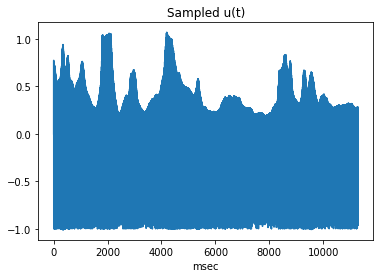

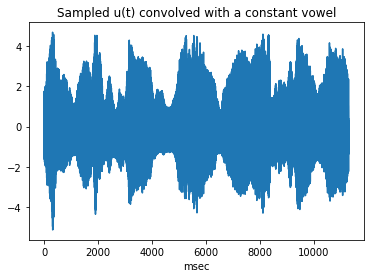

In [17]:
num_pitch_periods = 1500 # 15 gig of memory
vowel = 10
envelope_kernel_name = None # Sounds realistic with a longer lengthscale
envelope_lengthscale = 40. # Sounds more natural than the inferred value
# The longer the lengthscale, the more stable the resulting DGF waveform

prior = lf.generic_params_trajectory_prior(
    num_pitch_periods,
    envelope_kernel_name,
    envelope_lengthscale
)

t, u = lf.sample_dgf(
    num_pitch_periods,
    prior,
    seed=rng.integers(1000)
)
title(f'Sampled u(t)')
plot(t, u)
xlabel('msec')
show()

t, d = klatt.gen_vowel(vowel, u, t)
title(f'Sampled u(t) convolved with a constant vowel')
plot(t, d)
xlabel('msec')
show()
klatt.play(t, d)

In [18]:
x = lf.generic_params_prior().sample(seed=jaxkey())
lf.generic_params_to_dict(x, squeeze=True)

[Memory]322.1s, 5.4min  : Loading sample_lf_params...
[Memory]322.1s, 5.4min  : Loading run_nested...


{'T0': DeviceArray(6.28258895, dtype=float64),
 'Oq': DeviceArray(0.42981966, dtype=float64),
 'am': DeviceArray(0.70077399, dtype=float64),
 'Qa': DeviceArray(0.09538817, dtype=float64)}